In [245]:
import os
import tokenize
import io
import re
import gensim.downloader as api
import pandas as pd
import numpy as np
from numpy import asarray
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk import FreqDist

data_file = "ProblemSolutionPythonV3.csv" # obtained from Kaggle
preprocessed_file = "preprocessed_text.csv"
preprocessed_folder = "./processed"
pretrained_w2v = "glove-wiki-gigaword-50"
pretrained_w2v_file = str(pretrained_w2v) + "-word2vec.txt" 
w2v_filename =  'embedding_w2v_matrix.npy'


# Setting data visualization settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Preprocess Data

We first load the original data and analyse it.

In [246]:
data = pd.read_csv(data_file)

print(f"Data shape: {data.shape}\n")
data.info()
data.head()

Data shape: (3307, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3307 non-null   int64 
 1   Problem      3307 non-null   object
 2   Python Code  3306 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


,Unnamed: 0,Problem,Python Code
0,0,Write a NumPy program to repeat elements of an...,"import numpy as np\rx = np.repeat(3, 4)\rprint..."
1,1,Write a Python function to create and print a ...,def printValues():\n\tl = list()\n\tfor i in r...
2,2,Write a Python program to remove duplicates fr...,"import itertools\rnum = [[10, 20], [40], [30, ..."
3,3,Write a NumPy program to compute the x and y c...,import numpy as np\rimport matplotlib.pyplot a...
4,4,Write a Python program to alter a given SQLite...,import sqlite3\rfrom sqlite3 import Error\rdef...


We perform some initial cleaning on the dataset such as removing NaN rows.

In [247]:
data.set_index('Unnamed: 0', inplace=True, drop=True)
original_data = data.copy()
data = data.dropna()  # remove any rows with missing values
data = data.reset_index(drop=True)  # reset the index

print("Data shape: ", data.shape)
data.head()

Data shape:  (3306, 2)


,Problem,Python Code
0,Write a NumPy program to repeat elements of an...,"import numpy as np\rx = np.repeat(3, 4)\rprint..."
1,Write a Python function to create and print a ...,def printValues():\n\tl = list()\n\tfor i in r...
2,Write a Python program to remove duplicates fr...,"import itertools\rnum = [[10, 20], [40], [30, ..."
3,Write a NumPy program to compute the x and y c...,import numpy as np\rimport matplotlib.pyplot a...
4,Write a Python program to alter a given SQLite...,import sqlite3\rfrom sqlite3 import Error\rdef...


### Preprocess Text/Description Data

We apply various preprocessing methods on the descriptions such as: <br>
    - converting text to lowercase, <br>
    - removing punctuation, <br>
    - removing non-alphabetic characters, <br>
    - removing stop-words such as "a", "is", "the" etc., <br>
    - and apply lemmatization. <br>

In [248]:
# turn a dataset into clean tokens
def preprocess_problem_data(text):
    # Convert to lowercase
    text = text.lower()
    # remove punctuation from text
    punc_clean = re.sub(r'[^\w\s]', '', text)
    # split tokens
    words = punc_clean.split()
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # NOTE: we do not filter out short tokens since there are special char like x and y
    # lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return words

preprocessed = data.copy()
preprocessed['Problem'] = preprocessed['Problem'].apply(preprocess_problem_data)
preprocessed['Problem'].head()

0      [write, numpy, program, repeat, element, array]
1    [write, python, function, create, print, list,...
2    [write, python, program, remove, duplicate, li...
3    [write, numpy, program, compute, x, coordinate...
4    [write, python, program, alter, given, sqlite,...
Name: Problem, dtype: object

### Split Data into Train-Test

We then split the data into train and test sets.

In [249]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed['Problem'], preprocessed['Python Code'], test_size=0.2, random_state=42)

print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (2644,)
Test shape: (662,)


#### Create Vocabulary and Filter Text Data

We create a vocabulary from the training set and remove words that occur most and least frequently.

In [250]:
x_train_text = [' '.join(tokens) for tokens in x_train]

vocab_freq = Counter()
for text in x_train_text:
    words = text.split()  # Split the text into individual words
    vocab_freq.update(words)

print(f"Most common: {vocab_freq.most_common(10)}")
print(f"Unfiltered vocab length: {len(vocab_freq)}")

Most common: [('program', 2095), ('write', 1709), ('python', 1649), ('given', 735), ('list', 668), ('number', 538), ('array', 421), ('find', 412), ('numpy', 411), ('using', 404)]
Unfiltered vocab length: 1717


To identify threshold values for the maximum and minimum word frequencies, we generate a plot to visaulize the cumulative frequency of word occurrences within the vocabulary.

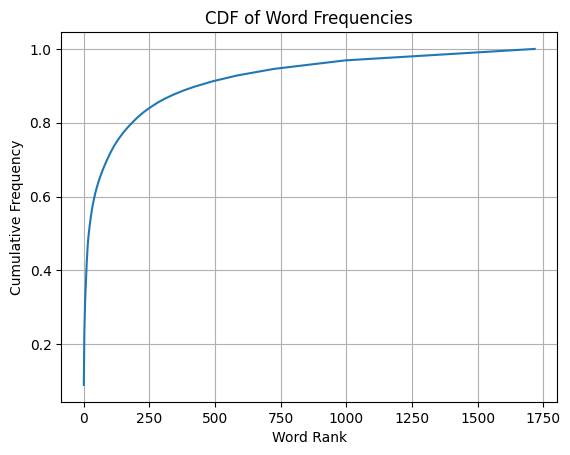

In [251]:
word_freq = np.array(list(vocab_freq.values()))
word_freq_sorted = np.sort(word_freq)[::-1]  # Sort in descending order
cumulative_freq = np.cumsum(word_freq_sorted)
cumulative_freq_norm = cumulative_freq / cumulative_freq[-1]

plt.plot(np.arange(1, len(cumulative_freq_norm) + 1), cumulative_freq_norm)
plt.xlabel('Word Rank')
plt.ylabel('Cumulative Frequency')
plt.title('CDF of Word Frequencies')
plt.grid(True)
plt.show()


The word with the highest frequency has the lowest rank and vice versa. Steep region (low x values) indicates that few words occur very frequently. To be precise, top 250 words dominate approximately 85% of the total word frequency. The flatter region indicates that frequencies are more evenly distributed among a larger set of words. 

The min frequency cutoff represents the point where the most frequent words start to appear. Words to the left of this cutoff are considered to dominate the dataset in terms of frequency. Hence, we choose the min frequency cutoff as 50 and remove them.  

The maximum frequency cutoff represents the point where the less frequent words are considered. Words to the right of this cutoff have relatively lower frequencies compared to the rest of the vocabulary. Hence, we choose this max frequency cutoff as 875.

In [252]:
# Filter out low and high frequency tokens
min_rank_cutoff = 15
max_rank_cutoff = 1000

# Convert the cutoff values in terms of rank to the actual frequency values
min_freq = word_freq_sorted[max_rank_cutoff - 1]  # -1 since 0-based indexing
max_freq = word_freq_sorted[min_rank_cutoff - 1]  
print(f"Min Freq: {min_freq}\nMax Freq: {max_freq}\n")
        
vocab = {token: freq for token, freq in vocab_freq.items() if min_freq <= freq <= max_freq}
vocab_length = len(vocab)

print(f"Filtered vocab length: {vocab_length}")
print(f"Filtered vocab: {vocab}\n")

print(x_train.head())

Min Freq: 1
Max Freq: 269

Filtered vocab length: 1703
Filtered vocab: {'check': 152, 'dictionary': 155, 'calculate': 74, 'lcm': 5, 'two': 230, 'print': 269, 'alternate': 3, 'node': 20, 'linked': 52, 'without': 48, 'recursion': 82, 'sum': 121, 'series': 106, 'test': 27, 'whether': 83, 'passed': 2, 'letter': 37, 'vowel': 10, 'stack': 16, 'doubly': 11, 'get': 135, 'elementwise': 18, 'remainder': 2, 'division': 7, 'extract': 66, 'symmetric': 5, 'tuples': 39, 'length': 70, 'present': 41, 'column': 177, 'dataframe': 161, 'remove': 90, 'specific': 57, 'item': 60, 'retrieve': 6, 'html': 20, 'code': 18, 'title': 4, 'text': 40, 'parent': 2, 'rotate': 5, 'deque': 9, 'object': 63, 'specified': 124, 'positive': 25, 'time': 75, 'triplet': 4, 'closest': 2, 'return': 33, 'three': 31, 'integer': 84, 'script': 5, 'take': 15, 'input': 42, 'user': 19, 'display': 48, 'back': 1, 'upper': 17, 'lower': 18, 'case': 22, 'create': 252, 'mean': 20, 'standard': 5, 'deviation': 4, 'data': 42, 'ip': 5, 'address': 1

We then filter the training and test sets based on the filtered vocabulary.

In [253]:
def filter_freq(data, vocab):
    filtered_data = []
    for line in data:
        filtered = ' '.join([token for token in line if token in vocab])
        filtered_data.append(filtered)

    filtered_data = pd.Series(filtered_data, index=data.index)
    
    return filtered_data


x_train = filter_freq(x_train, vocab)
x_test = filter_freq(x_test, vocab)

x_train.head()

69                                   check dictionary
3000                                calculate lcm two
2893    print alternate node linked without recursion
2954                                       sum series
436                  test whether passed letter vowel
dtype: object

### Preprocess Code Data

We then preprocess Python source code by tokenizing it and then filtering out tokens that are not relevant for further analysis.

In [254]:
def preprocess_code_data(code):
    # Convert code to format accepted by Python's own tokenizer that can read Python syntax
    tokens = tokenize.generate_tokens(io.StringIO(code).readline)

    tokenized_code = []
    try: 
        for token in tokens:
            # Include only the code tokens and exclude space, commets etc.
            if token.type in (tokenize.NAME, tokenize.OP, tokenize.NUMBER, tokenize.STRING):
                tokenized_code.append(token.string)
    
    # Skip code that ends with an error, e.g. missing some closing brackets.
    except tokenize.TokenError:
        return None
    except IndentationError:
        return None
    
    return tokenized_code

preprocessed['Python Code'] = preprocessed['Python Code'].apply(preprocess_code_data)

skipped_rows = preprocessed['Python Code'].isnull().sum()

print(f"Number of skipped rows: {skipped_rows}")

preprocessed['Python Code'].head()

Number of skipped rows: 5


0    [import, numpy, as, np, x, =, np, ., repeat, (...
1    [def, printValues, (, ), :, l, =, list, (, ), ...
2    [import, itertools, num, =, [, [, 10, ,, 20, ]...
3    [import, numpy, as, np, import, matplotlib, .,...
4    [import, sqlite3, from, sqlite3, import, Error...
Name: Python Code, dtype: object

We eliminate the rows that were excluded due to improperly formatted or incorrectly structured code and save the resulting file as a CSV.

In [255]:
# Remove NA
preprocessed.dropna(subset=['Problem', 'Python Code'], inplace=True)  # remove any rows with missing values
preprocessed.reset_index(drop=True, inplace=True)
print(f"Data shape: {preprocessed.shape}")

# Save preprocessed data
if not os.path.exists(preprocessed_folder):
    os.makedirs(preprocessed_folder)

path = os.path.join(preprocessed_folder, preprocessed_file)
preprocessed.to_csv(path, sep=',', index_label='Id')

preprocessed.head()

Data shape: (3301, 2)


,Problem,Python Code
0,"[write, numpy, program, repeat, element, array]","[import, numpy, as, np, x, =, np, ., repeat, (..."
1,"[write, python, function, create, print, list,...","[def, printValues, (, ), :, l, =, list, (, ), ..."
2,"[write, python, program, remove, duplicate, li...","[import, itertools, num, =, [, [, 10, ,, 20, ]..."
3,"[write, numpy, program, compute, x, coordinate...","[import, numpy, as, np, import, matplotlib, .,..."
4,"[write, python, program, alter, given, sqlite,...","[import, sqlite3, from, sqlite3, import, Error..."


## Vectorize

### Encode dataset

We first tokenize the training set and find the maximum length of description data.

In [260]:
tokenizer = Tokenizer()
tokenizer.filters = ""  # Remove default filters
tokenizer.lower = False  
tokenizer.fit_on_texts(x_train) 

# Find maximum sequence length
max_seq_len = max([len(line.split()) for line in x_train])
print(f'Max seq length: {max_seq_len}')

Max seq length: 47


We then integer encode and pad the sequences to encode the data.

In [261]:
def encode_data(text_line, max_len, tokenizer):
    encoded = tokenizer.texts_to_sequences(text_line)
    padded = pad_sequences(encoded, maxlen=max_len, padding='post')

    return padded

# Encode Data
x_train_encoded = encode_data(x_train, max_seq_len, tokenizer)
x_test_encoded = encode_data(x_test, max_seq_len, tokenizer)
y_train_encoded = encode_data(y_train, max_seq_len, tokenizer)
y_test_encoded = encode_data(y_test, max_seq_len, tokenizer)

print(f"Train shape: {x_train_encoded.shape}")
print(f"Test shape: {x_test_encoded.shape}")
print(f"Train shape: {y_train_encoded.shape}")
print(f"Test shape: {y_test_encoded.shape}")
print(f"x_train_encoded: {x_train_encoded}")

Train shape: (2644, 47)
Test shape: (662, 47)
Train shape: (2644, 47)
Test shape: (662, 47)
x_train_encoded: [[  7   6   0 ...   0   0   0]
 [ 28 401   3 ...   0   0   0]
 [  1 565 138 ...   0   0   0]
 ...
 [  2   6   3 ...   0   0   0]
 [  2   5 204 ...   0   0   0]
 [ 71 590  10 ...   0   0   0]]


### Word2Vec

We load a pretrained Word2Vec embedding model and build a embedding matrix based on the words in our tokenized training set.

In [264]:
DIM = 50

def load_embedding():
    file_path = os.path.join(preprocessed_folder, pretrained_w2v_file)
    if not os.path.exists(file_path):
        print("Downloading model...")
        model = api.load("glove-wiki-gigaword-50")
        model.save_word2vec_format(file_path, binary=False)
    # else
    print("Loading w2v model...")
    file = open(file_path, 'r', encoding='utf8')
    lines = file.readlines()[1:]
    file.close()
    
    # Map words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')

    return embedding


loaded_embedding = load_embedding()

Loading w2v model...


In [263]:
def build_matrix(embedding, tokenizer):
    # Build an embedding matrix
    total_count = 0
    na_count = 0
    
    matrix = np.zeros((vocab_length + 1, DIM)) # +1 for unknown words
    for token, i in tokenizer.word_index.items():
        if token in embedding.keys():
            matrix[i] = embedding.get(token)
        else:
            na_count += 1
        total_count += 1
    print(f'NA/All words: {str(na_count)}/{total_count}')
    print(f"matrix shape: {matrix.shape}")

    # Save the matrix
    with open(os.path.join(preprocessed_folder, pretrained_w2v_file), 'w') as file:
        file.write('\n'.join(' '.join(str(x) for x in line) for line in matrix))
    #np.save(os.path.join(preprocessed_folder, pretrained_w2v_file), matrix)
    
    return matrix


w2v_embedding_matrix = build_matrix(loaded_embedding, tokenizer)

NA/All words: 218/1703
matrix shape: (1704, 50)
